In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt

from collections import Counter

sys.path.append("../helpers/")
from impresso_id import *
from filtering import *

sns.set()

journal_palette = sns.color_palette(cc.glasbey, n_colors=12)

data_path = "data"

## Analysis conducted on manual annotation corrections

In [2]:
df_labels_total = pd.read_parquet("inconsistencies.parquet")
df_labels_total["year"] = df_labels_total["pid"].apply(lambda x: get_year(x))
df_labels_total["month"] = df_labels_total["pid"].apply(lambda x: get_month(x))
df_labels_total["day"] = df_labels_total["pid"].apply(lambda x: get_day(x))
df_labels_total["journal"] = df_labels_total["pid"].apply(lambda x: get_journal(x))
df_labels_total["edition"] = df_labels_total["pid"].apply(lambda x: get_edition(x))
df_labels_total["page"] = df_labels_total["pid"].apply(lambda x: get_page(x))
df_labels_total["meta_issue_id"] = df_labels_total["pid"].apply(lambda x: get_meta_issue_id(x))

print(df_labels_total.shape)
df_labels_total.head()

(2061, 15)


,pid,tag,label,x,y,width,height,annotator,year,month,day,journal,edition,page,meta_issue_id
0,luxwort-1942-07-24-a-p0004,table,None,996,1071,182,98,0,1942,7,24,luxwort,a,4,luxwort-1942-07-24-a
1,luxwort-1942-07-24-a-p0004,table,None,995,838,182,218,0,1942,7,24,luxwort,a,4,luxwort-1942-07-24-a
2,gazgrdlux-1878-09-29-a-p0003,table,None,865,69,260,728,0,1878,9,29,gazgrdlux,a,3,gazgrdlux-1878-09-29-a
3,luxwort-1887-09-29-a-p0003,table,None,330,809,207,507,0,1887,9,29,luxwort,a,3,luxwort-1887-09-29-a
4,luxwort-1873-01-28-a-p0004,table,None,28,1269,262,422,0,1873,1,28,luxwort,a,4,luxwort-1873-01-28-a


In [3]:
with open("NLL_metadata_images.json", "r") as f:
    metadata = json.load(f)

df_labels_total["total_area"] = df_labels_total.apply(lambda x: 100*x['width']*x['height']/(metadata[x['pid']]['resized_height']*metadata[x['pid']]['resized_width']), axis=1)
df_labels_total["missing_area"] = df_labels_total.apply(lambda x: 100*x['width']*x['height']/(metadata[x['pid']]['resized_height']*metadata[x['pid']]['resized_width']) if x['label'] is not None else 0, axis=1)

In [4]:
df_labels_per_pid = df_labels_total.groupby('pid').agg({'label': Counter, 
                                                        'year': max, 
                                                        'journal': max, 
                                                        'page': max,
                                                        'tag': Counter,
                                                        'height': np.mean,
                                                        'width': np.mean,
                                                        'total_area': np.sum,
                                                        'missing_area': np.sum})

df_labels_per_pid['correct'] = df_labels_per_pid['label'].apply(lambda x: x[None])
df_labels_per_pid['a'] = df_labels_per_pid['label'].apply(lambda x: x['a'])
df_labels_per_pid['b'] = df_labels_per_pid['label'].apply(lambda x: x['b'])
df_labels_per_pid['c'] = df_labels_per_pid['label'].apply(lambda x: x['c'])
df_labels_per_pid['a+b'] = df_labels_per_pid['a'] + df_labels_per_pid['b']
df_labels_per_pid = df_labels_per_pid.drop('label', axis=1)

print(df_labels_per_pid.shape)
df_labels_per_pid.head()

(666, 13)


,year,journal,page,tag,height,width,total_area,missing_area,correct,a,b,c,a+b
pid,,,,,,,,,,,,,
avenirgdl-1868-05-28-a-p0004,1868,avenirgdl,4,"{'table': 5, 'transport schedule': 4}",64.555556,299.111111,9.027449,5.748084,5,4,0,0,4
avenirgdl-1868-07-23-a-p0004,1868,avenirgdl,4,"{'table': 4, 'transport schedule': 8}",168.750000,298.333333,27.941533,11.474601,4,5,3,0,8
avenirgdl-1868-11-04-a-p0004,1868,avenirgdl,4,"{'table': 2, 'transport schedule': 7}",124.555556,370.555556,26.249992,10.147627,2,7,0,0,7
avenirgdl-1869-02-16-a-p0004,1869,avenirgdl,4,"{'table': 3, 'transport schedule': 7}",150.100000,356.400000,30.444544,10.302773,3,7,0,0,7
avenirgdl-1869-02-22-a-p0004,1869,avenirgdl,4,"{'table': 7, 'transport schedule': 3}",194.800000,355.900000,29.908328,8.468654,7,3,0,0,3


Mean (A): 0.8378378378378378
Mean (B): 0.1816816816816817
Mean (A+B): 1.0195195195195195
Median (A): 0.0
Median (B): 0.0


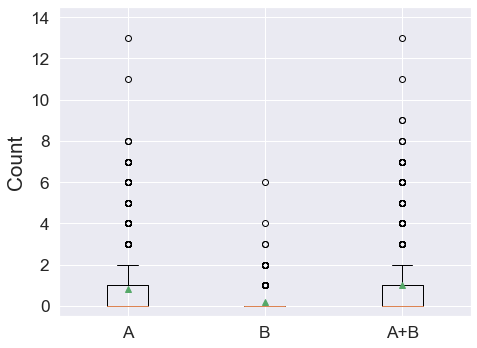

In [5]:
fig, ax = plt.subplots(figsize=(7,5))
print(f"Mean (A): {np.mean(df_labels_per_pid['a'])}")
print(f"Mean (B): {np.mean(df_labels_per_pid['b'])}")
print(f"Mean (A+B): {np.mean(df_labels_per_pid['a+b'])}")
print(f"Median (A): {np.median(df_labels_per_pid['a'])}")
print(f"Median (B): {np.median(df_labels_per_pid['b'])}")
plt.boxplot([df_labels_per_pid['a'], df_labels_per_pid['b'], df_labels_per_pid['a+b']], 
            labels=['A', 'B', 'A+B'], showmeans=True)
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylim([-0.5, 14.5])
plt.ylabel("Count", fontsize='xx-large')
plt.tight_layout()
plt.show()

In [6]:
total_counter = {}
for counter in df_labels_per_pid['tag']:
    for k, count in counter.items():
        if k not in total_counter:
            total_counter[k] = []
        total_counter[k].append(count)

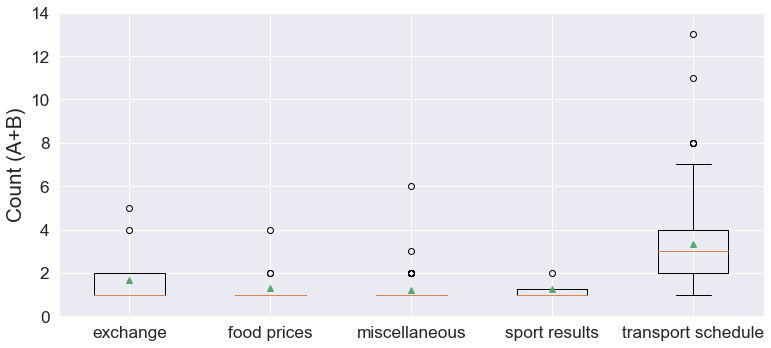

In [7]:
fig, ax = plt.subplots(figsize=(11,5))
plt.boxplot([total_counter[k] for k in sorted(list(total_counter.keys())[1:])], 
            labels=sorted(list(total_counter.keys())[1:]), showmeans=True)
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylabel("Count (A+B)", fontsize='xx-large')
plt.ylim([0, 14])
plt.tight_layout()
plt.show()

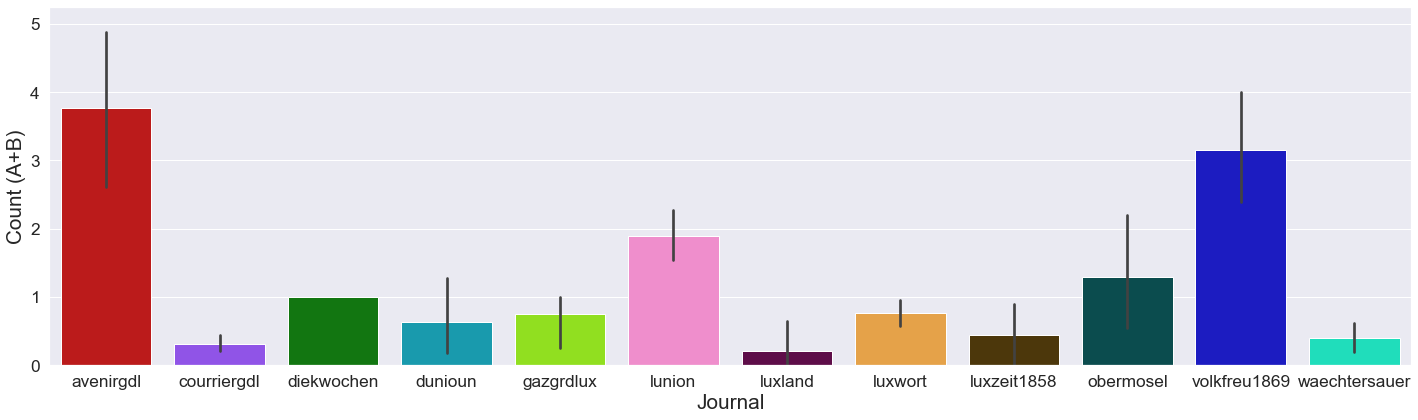

In [8]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data=df_labels_per_pid, x='journal', y='a+b', palette=journal_palette)
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylim([0, 5.25])
plt.ylabel("Count (A+B)", fontsize='xx-large')
plt.xlabel("Journal", fontsize='xx-large')
plt.tight_layout()
plt.show()

Mean missing area: 9.210852302013587


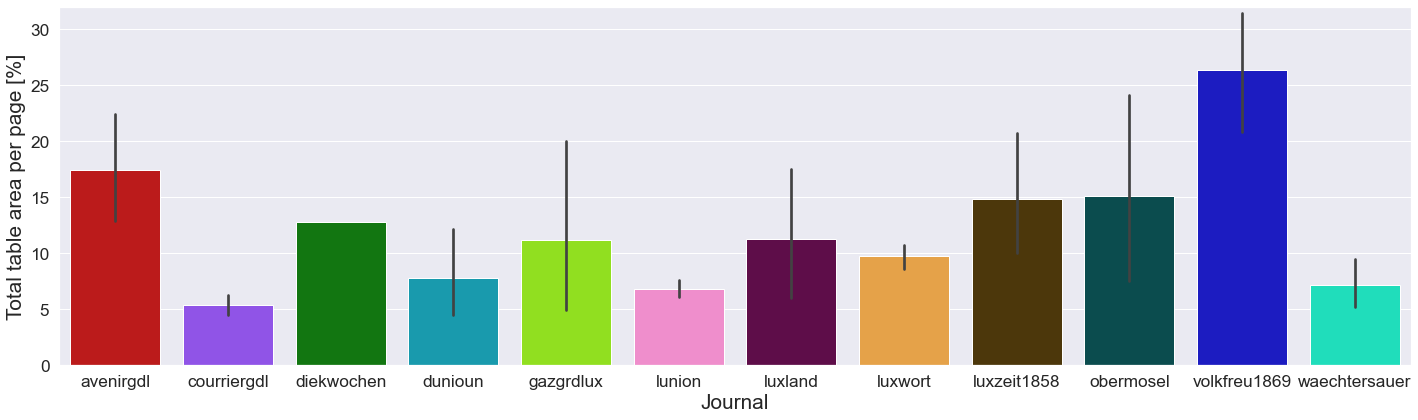

In [9]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data=df_labels_per_pid, x='journal', y='total_area', palette=journal_palette)
print(f"Mean missing area: {df_labels_per_pid['total_area'].mean()}")
plt.ylim([0, 32])
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.xlabel("Journal", fontsize='xx-large')
plt.ylabel("Total table area per page [%]", fontsize='xx-large')
plt.tight_layout()
plt.show()

Mean missing area: 2.4196388397610953


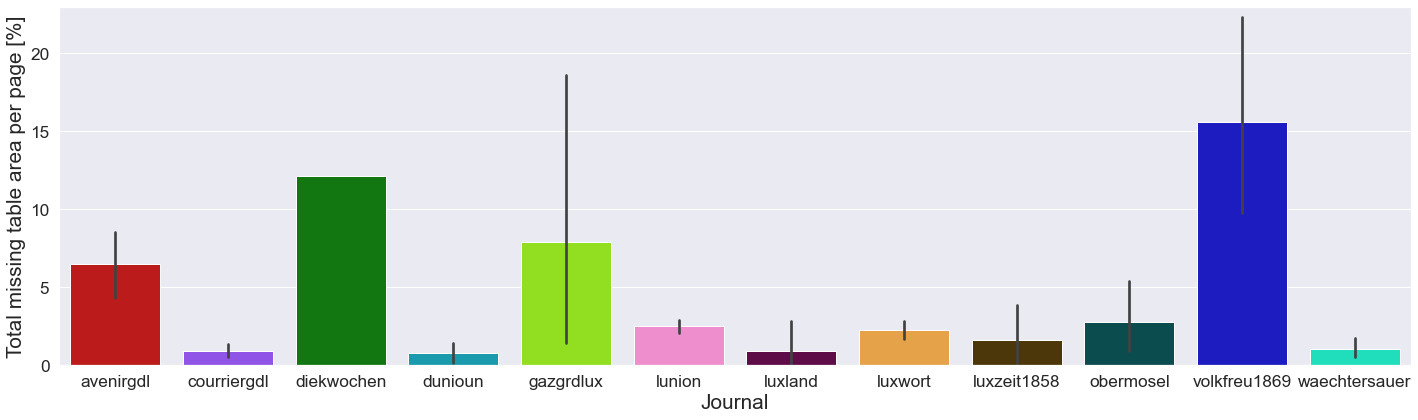

In [10]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data=df_labels_per_pid, x='journal', y='missing_area', palette=journal_palette)
print(f"Mean missing area: {df_labels_per_pid['missing_area'].mean()}")
plt.ylim([0, 23])
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.xlabel("Journal", fontsize='xx-large')
plt.ylabel("Total missing table area per page [%]", fontsize='xx-large')
plt.tight_layout()
plt.show()

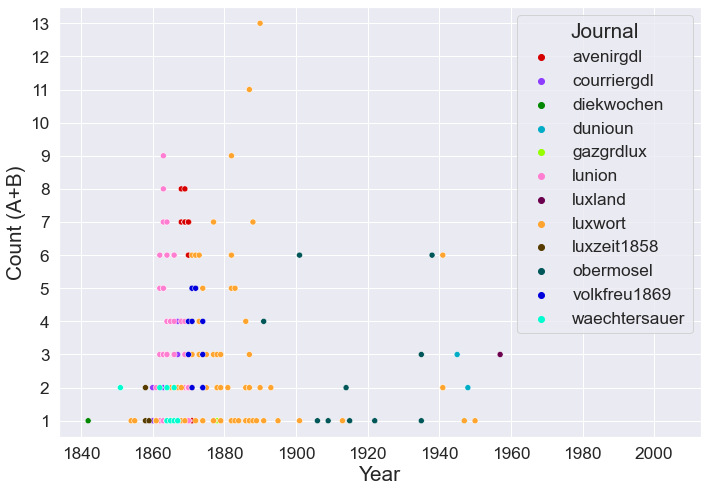

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df_labels_per_pid, x='year', y='a+b', hue='journal', palette=journal_palette)
plt.ylim([0.5, 13.5])
ax.axes.yaxis.set_ticks(range(1, 14)) 
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylabel("Count (A+B)", fontsize='xx-large')
legend = plt.legend(title='Journal', fontsize='x-large')
plt.setp(legend.get_title(),fontsize='xx-large')
plt.xlabel("Year", fontsize='xx-large')
plt.tight_layout()
plt.show()

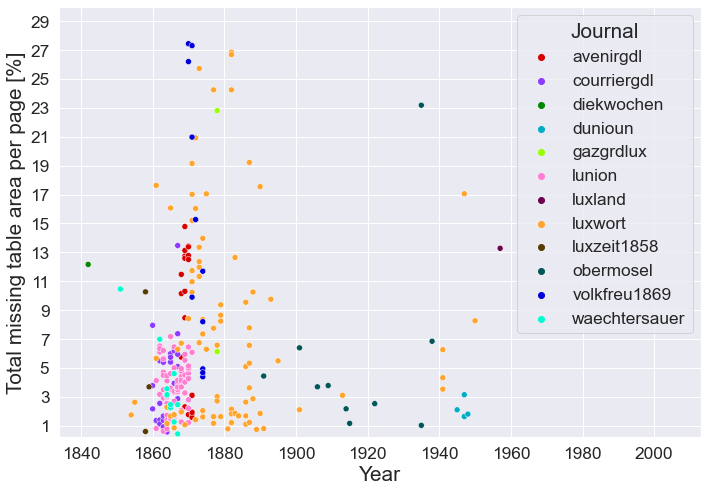

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df_labels_per_pid, x='year', y='missing_area', hue='journal', palette=journal_palette)
plt.ylim([0.2, 30])
ax.axes.yaxis.set_ticks(np.arange(1, 30, 2)) 
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylabel("Total missing table area per page [%]", fontsize='xx-large')
plt.xlabel("Year", fontsize='xx-large')
legend = plt.legend(title='Journal', fontsize='x-large')
plt.setp(legend.get_title(),fontsize='xx-large')
plt.tight_layout()
plt.show()

avenirgdl


<Figure size 720x504 with 0 Axes>

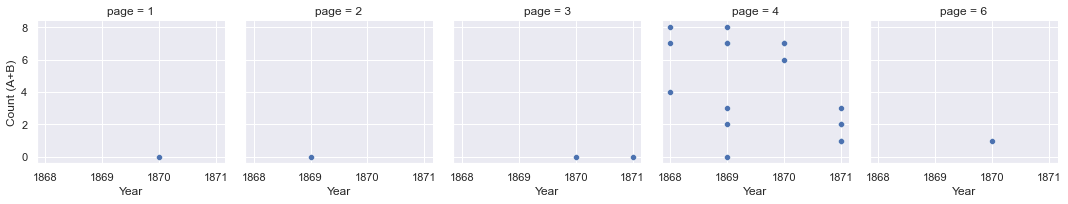

courriergdl


<Figure size 720x504 with 0 Axes>

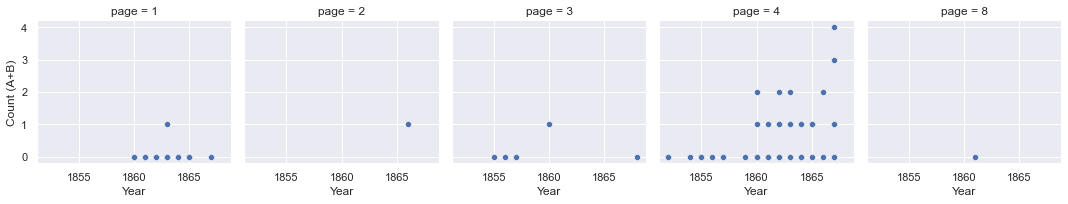

diekwochen


<Figure size 720x504 with 0 Axes>

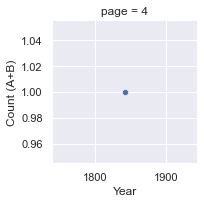

dunioun


<Figure size 720x504 with 0 Axes>

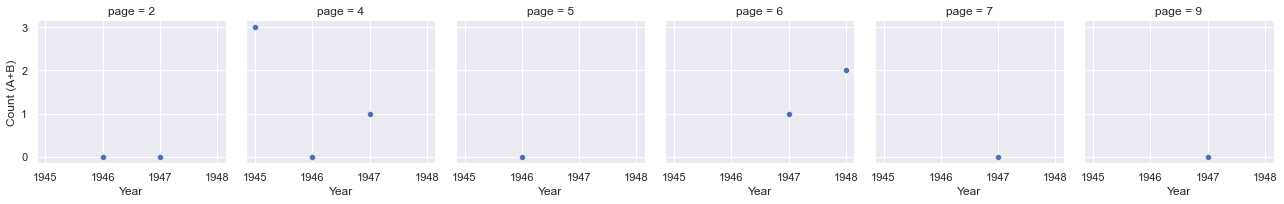

gazgrdlux


<Figure size 720x504 with 0 Axes>

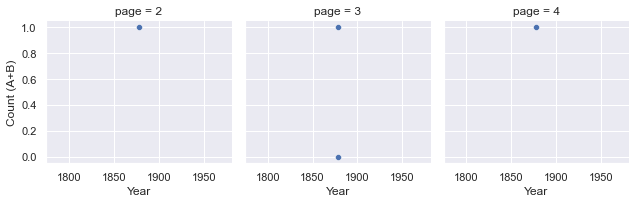

lunion


<Figure size 720x504 with 0 Axes>

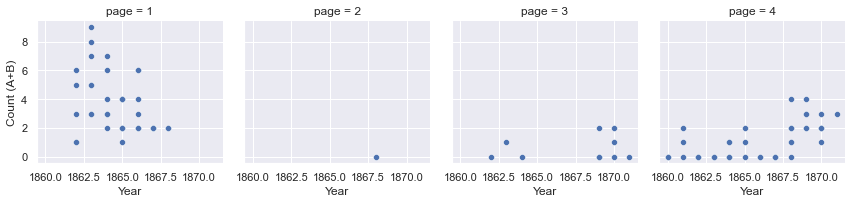

luxland


<Figure size 720x504 with 0 Axes>

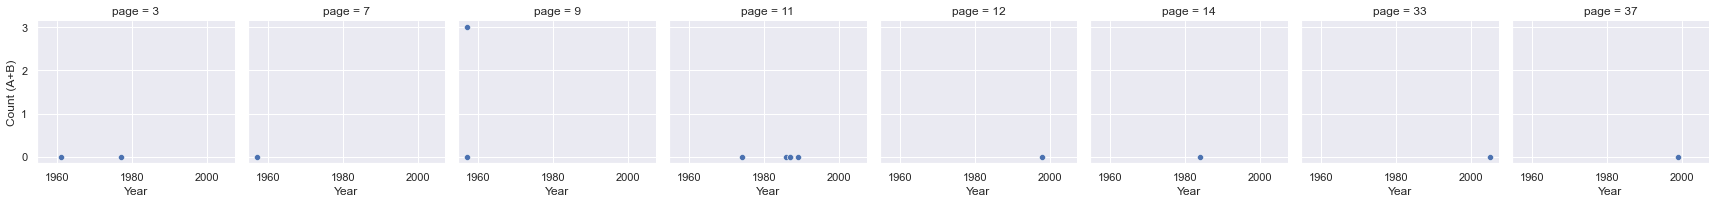

luxwort


<Figure size 720x504 with 0 Axes>

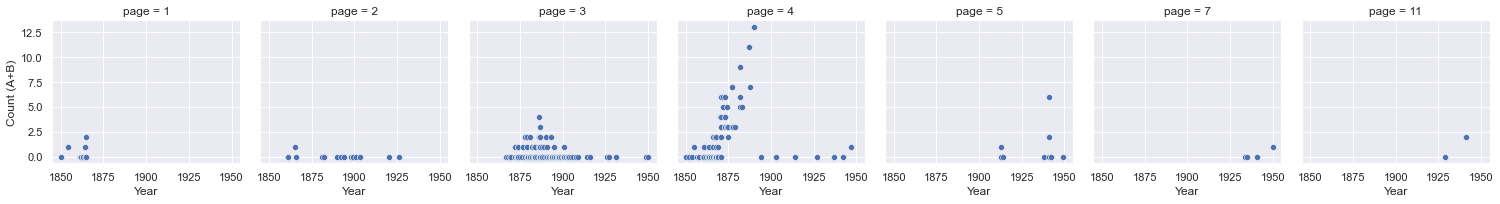

luxzeit1858


<Figure size 720x504 with 0 Axes>

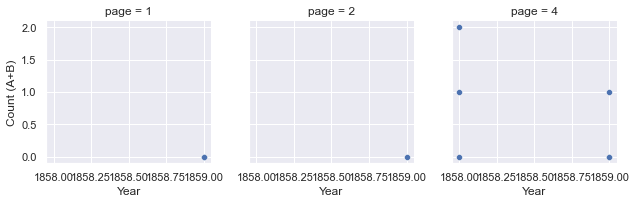

obermosel


<Figure size 720x504 with 0 Axes>

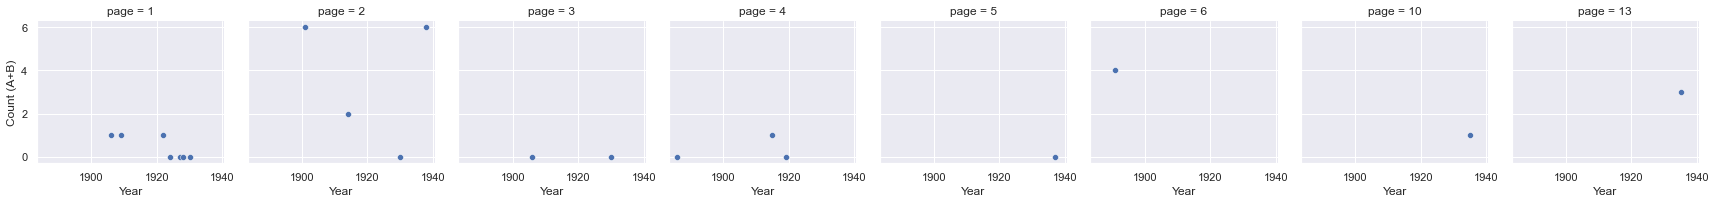

volkfreu1869


<Figure size 720x504 with 0 Axes>

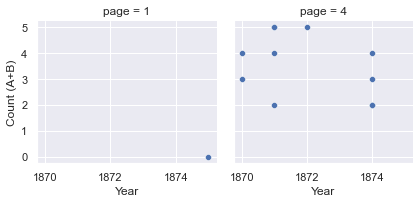

waechtersauer


<Figure size 720x504 with 0 Axes>

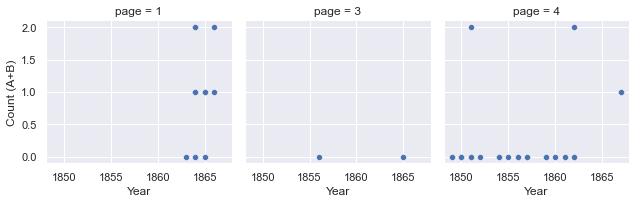

In [13]:
for journal in df_labels_per_pid['journal'].unique():
    plt.figure(figsize=(10,7))
    g = sns.FacetGrid(df_labels_per_pid[df_labels_per_pid['journal'] == journal], col="page")
    g.map(sns.scatterplot, "year", 'a+b')
    print(journal)
    g.set_axis_labels("Year", "Count (A+B)")
    g.tight_layout()
    plt.show()

avenirgdl


<Figure size 720x504 with 0 Axes>

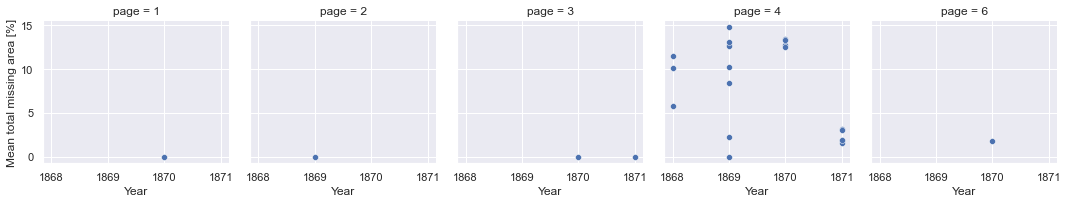

courriergdl


<Figure size 720x504 with 0 Axes>

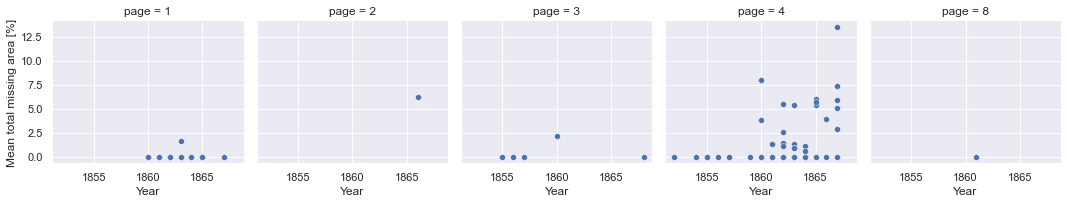

diekwochen


<Figure size 720x504 with 0 Axes>

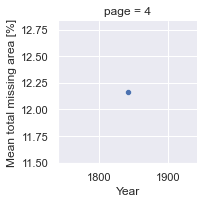

dunioun


<Figure size 720x504 with 0 Axes>

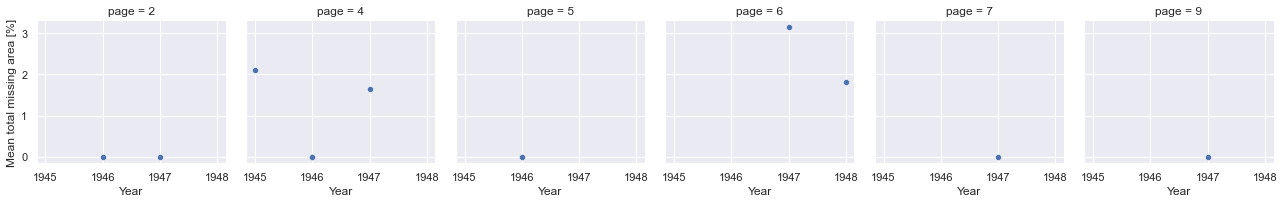

gazgrdlux


<Figure size 720x504 with 0 Axes>

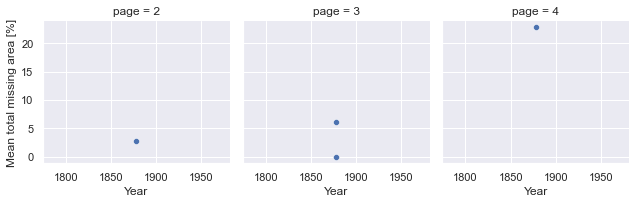

lunion


<Figure size 720x504 with 0 Axes>

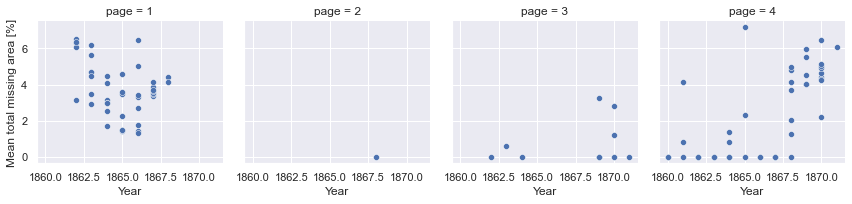

luxland


<Figure size 720x504 with 0 Axes>

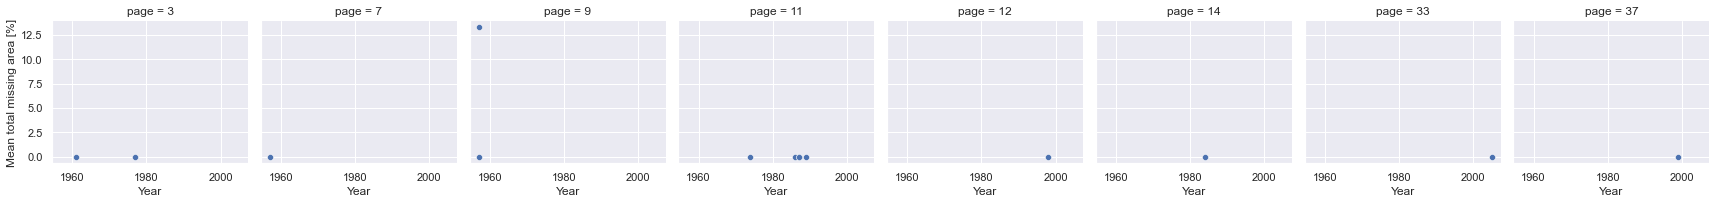

luxwort


<Figure size 720x504 with 0 Axes>

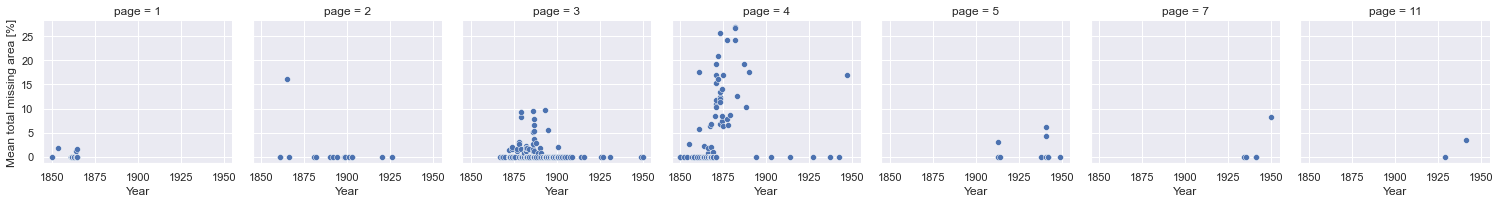

luxzeit1858


<Figure size 720x504 with 0 Axes>

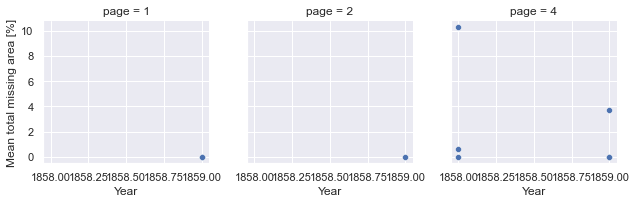

obermosel


<Figure size 720x504 with 0 Axes>

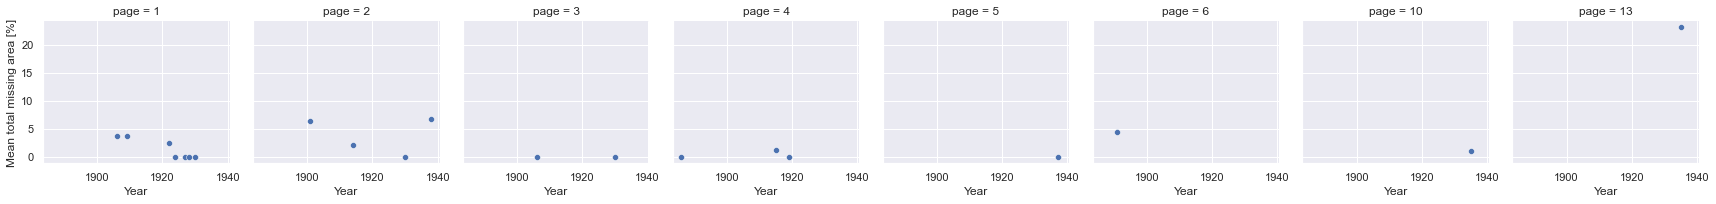

volkfreu1869


<Figure size 720x504 with 0 Axes>

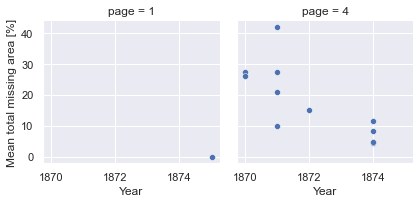

waechtersauer


<Figure size 720x504 with 0 Axes>

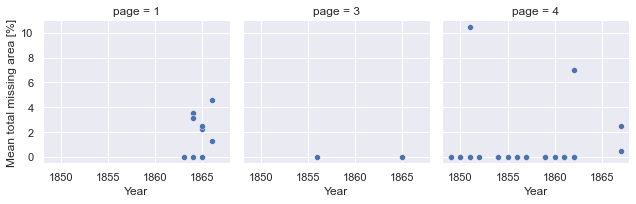

In [14]:
for journal in df_labels_per_pid['journal'].unique():
    plt.figure(figsize=(10,7))
    g = sns.FacetGrid(df_labels_per_pid[df_labels_per_pid['journal'] == journal], col="page")
    g.map(sns.scatterplot, "year", 'missing_area')
    print(journal)
    g.set_axis_labels("Year", "Mean total missing area [%]")
    g.tight_layout()
    plt.show()

The identified problematic clusters are filtered using the method below.

In [15]:
df_labels_per_pid_filtered = filter_problematic_clusters(df_labels_per_pid)

A post-filtering analysis is presented below.

Mean (A): 0.13924050632911392
Mean (B): 0.18227848101265823
Mean (A+B): 0.32151898734177214


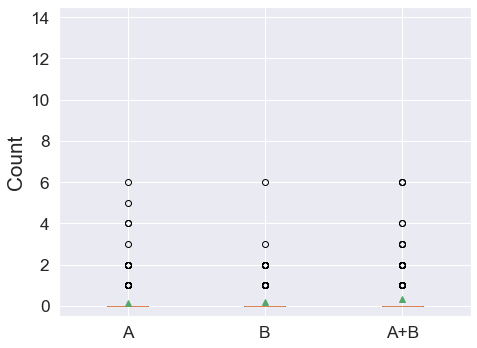

In [16]:
fig, ax = plt.subplots(figsize=(7,5))
print(f"Mean (A): {np.mean(df_labels_per_pid_filtered['a'])}")
print(f"Mean (B): {np.mean(df_labels_per_pid_filtered['b'])}")
print(f"Mean (A+B): {np.mean(df_labels_per_pid_filtered['a+b'])}")
plt.boxplot([df_labels_per_pid_filtered['a'], df_labels_per_pid_filtered['b'], df_labels_per_pid_filtered['a+b']], 
            labels=['A', 'B', 'A+B'], showmeans=True)
plt.ylim([-0.5, 14.5])
plt.ylabel("Count", fontsize='xx-large')
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.tight_layout()
plt.show()

In [17]:
total_counter_filtered = {}
for counter in df_labels_per_pid_filtered['tag']:
    for k, count in counter.items():
        if k not in total_counter_filtered:
            total_counter_filtered[k] = []
        total_counter_filtered[k].append(count)

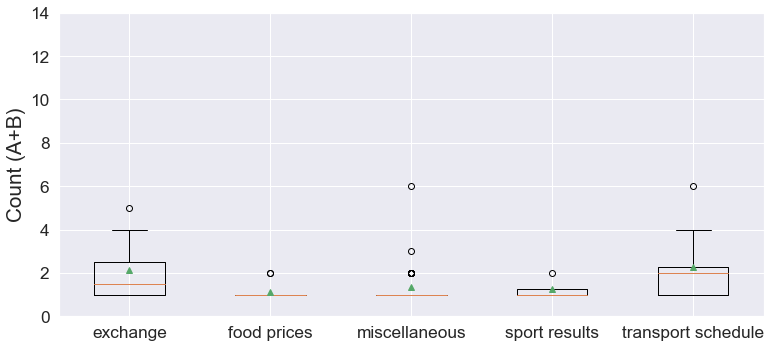

In [18]:
fig, ax = plt.subplots(figsize=(11,5))
plt.boxplot([total_counter_filtered[k] for k in sorted(list(total_counter_filtered.keys())[1:])], 
            labels=sorted(list(total_counter_filtered.keys())[1:]), showmeans=True)
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylim([0, 14])
plt.ylabel("Count (A+B)", fontsize='xx-large')
plt.tight_layout()
plt.show()

In [19]:
df_labels_per_pid_filtered.loc['diekwochen'] = [None, 'diekwochen', 0, None, 0, 0, 0, 0, 0,0 ,0, 0,0 ]
df_labels_per_pid_filtered = df_labels_per_pid_filtered.sort_index()

/Users/assa/opt/miniconda3/envs/pdm/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


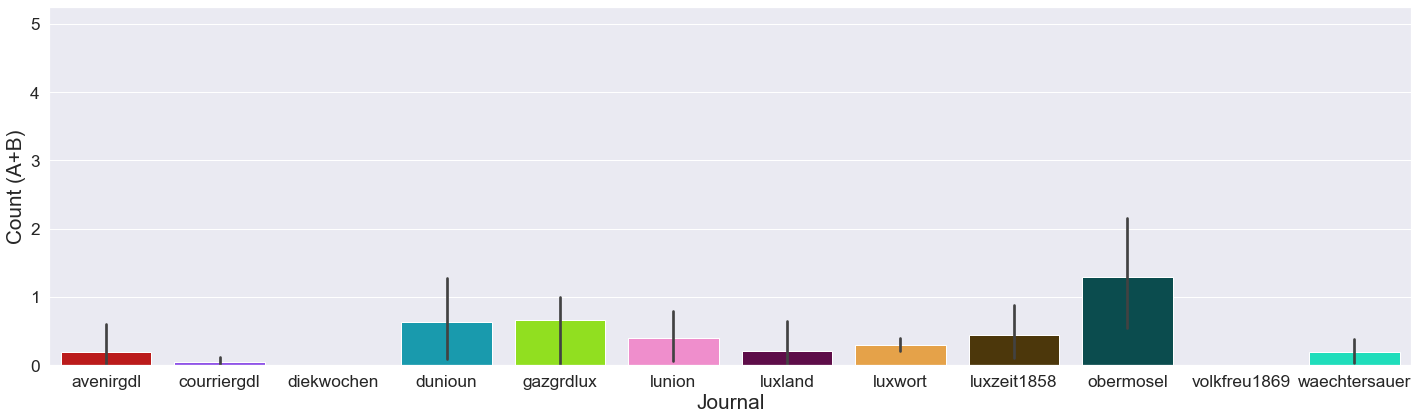

In [20]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data=df_labels_per_pid_filtered, x='journal', y='a+b', palette=journal_palette)
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.ylim([0, 5.25])
plt.ylabel("Count (A+B)", fontsize='xx-large')
plt.xlabel("Journal", fontsize='xx-large')
plt.tight_layout()
plt.show()

Mean missing area: 6.861678341237688


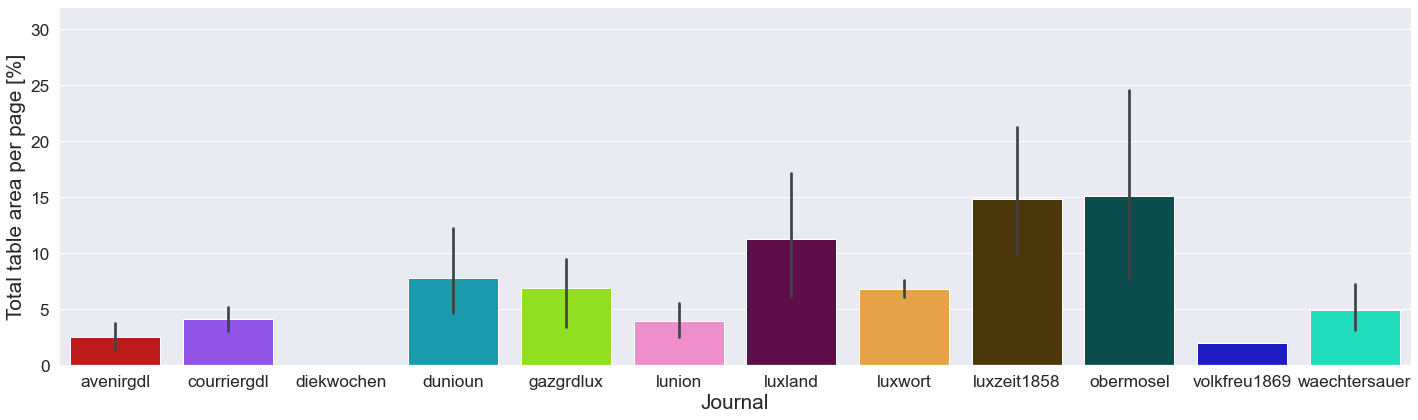

In [21]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data=df_labels_per_pid_filtered, x='journal', y='total_area', palette=journal_palette)
print(f"Mean missing area: {df_labels_per_pid_filtered['total_area'].mean()}")
plt.xlabel("Journal", fontsize='xx-large')
plt.ylabel("Total table area per page [%]", fontsize='xx-large')
plt.ylim([0, 32])
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.tight_layout()
plt.show()

Mean missing area: 0.8086964606208752


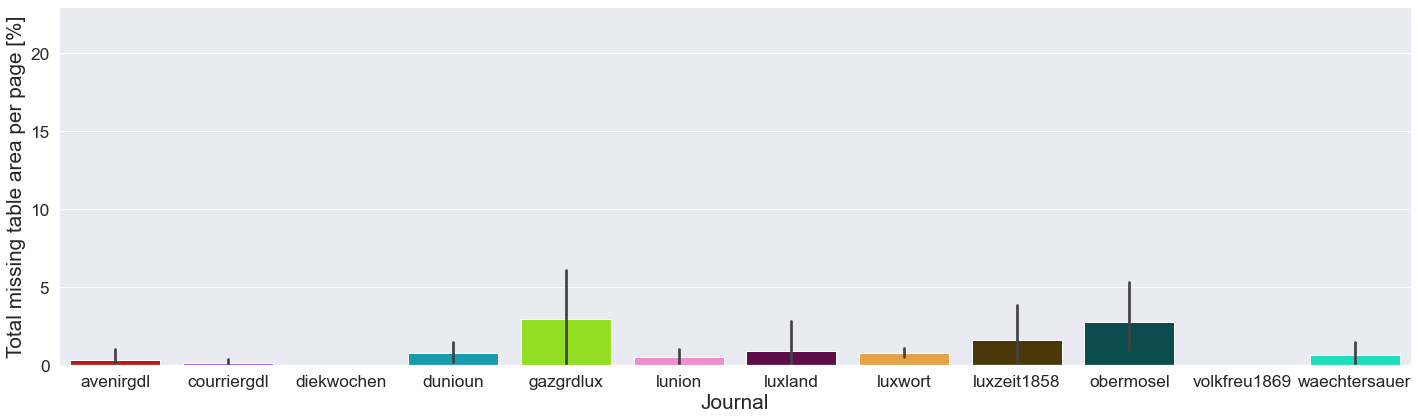

In [22]:
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(data=df_labels_per_pid_filtered, x='journal', y='missing_area', palette=journal_palette)
print(f"Mean missing area: {df_labels_per_pid_filtered['missing_area'].mean()}")
plt.ylim([0, 23])
plt.xlabel("Journal", fontsize='xx-large')
plt.ylabel("Total missing table area per page [%]", fontsize='xx-large')
ax.tick_params(axis='both', which='major', labelsize='x-large')
plt.tight_layout()
plt.show()